**This project explores the various ways to model and solve linear programming in Python. The PuLP and Pyomo libraries are popular and support many solvers, such as CBC, GLPK, and CPLEX. I use CBC with PuLP and GLPK with Pyomo below. One can also use solvers directly, and this is shown with the CPLEX/DOCPLEX solvers. Using a solver directly gives more control and access to advanced features and capabilities. However, sensitivity report (sensitivity analysis) output differs depending on which solver API is used. SciPy can also be used for linear programming but has solver limitations.**

# Home Improvement Exhibition
A 20,000 square foot convention center is scheduling for a home improvement trade show. Convention floor space is sold to four different categories of exhibitors. Different categories of exhibitors are charged different amounts for the three-day event based on the amount of space they require and the popularity of the type of exhibit. The decision variables are the number of each type of exhibitor. Let X<sub>i</sub> = the number of exhibitor type i to schedule (i = B, A, D and S). A fractional number of exhibitors is not allowed, and they should be whole numbers. Also, the number of each type of exhibitor should be at least 15% of the total number of exhibitors:<br>
$$\frac{X_i}{X_B + X_A + X_D + X_S} >= 0.15$$

## Model Inputs
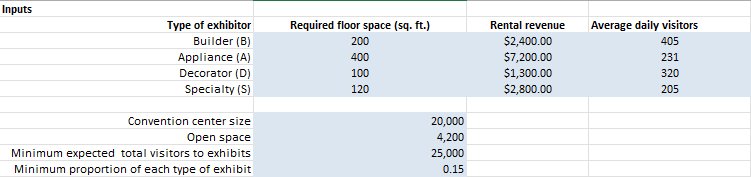

## Maximize Objective Function
Revenue = \\$2,400 X<sub>B</sub> + \\$7,200 X<sub>A</sub> + \\$1,300 X<sub>D</sub> + \\$2,800 X<sub>S</sub>

## Constraints
**Space Constraint:** 200 X<sub>B</sub> + 400 X<sub>A</sub> + 100 X<sub>D</sub> + 120 X<sub>S</sub> <= 20,000 - 4,200<br>
**Total Visitors to Exhibits:** 405 X<sub>B</sub> + 231 X<sub>A</sub> + 320 X<sub>D</sub> + 205 X<sub>S</sub> >= 25,000<br>
**Integers only:** X<sub>B</sub>, X<sub>A</sub>, X<sub>D</sub>, X<sub>S</sub><br>

*Rewrite fraction above in linear form for each exhibitor type:*<br>
**Minimum B:** 0.85 X<sub>B</sub> - 0.15 X<sub>A</sub> - 0.15 X<sub>D</sub> - 0.15 X<sub>S</sub> >= 0<br>
**Minimum A:** 0.85 X<sub>A</sub> - 0.15 X<sub>B</sub> - 0.15 X<sub>D</sub> - 0.15 X<sub>S</sub> >= 0<br>
**Minimum D:** 0.85 X<sub>D</sub> - 0.15 X<sub>B</sub> - 0.15 X<sub>A</sub> - 0.15 X<sub>S</sub> >= 0<br>
**Minimum S:** 0.85 X<sub>S</sub> - 0.15 X<sub>B</sub> - 0.15 X<sub>A</sub> - 0.15 X<sub>D</sub> >= 0

## CBC (PuLP)

In [1]:
def run_pulp_model(rhs1, rhs2, rhs3, rhs4, rhs5, rhs6):
    model_pulp = pulp.LpProblem('linear_programming', LpMaximize)
    
    # Declare decision variables and make them continuous
    x1 = LpVariable('xb', lowBound = 0, cat = 'Continuous')
    x2 = LpVariable('xa', lowBound = 0, cat = 'Continuous')
    x3 = LpVariable('xd', lowBound = 0, cat = 'Continuous')
    x4 = LpVariable('xs', lowBound = 0, cat = 'Continuous')
    
    # Declare objective
    model_pulp += 2400*x1 + 7200*x2 + 1300*x3 + 2800*x4
    
    # Declare constraints
    model_pulp += 200*x1 + 400*x2 + 100*x3 + 120*x4 <= rhs1
    model_pulp += 405*x1 + 231*x2 + 320*x3 + 205*x4 >= rhs2
    model_pulp += 0.85*x1 - 0.15*x2 - 0.15*x3 - 0.15*x4 >= rhs3
    model_pulp += -0.15*x1 + 0.85*x2 - 0.15*x3 - 0.15*x4 >= rhs4
    model_pulp += -0.15*x1 - 0.15*x2 + 0.85*x3 - 0.15*x4 >= rhs5
    model_pulp += -0.15*x1 - 0.15*x2 - 0.15*x3 + 0.85*x4 >= rhs6
    
    return model_pulp, x1, x2, x3, x4


In [2]:
from pulp import *

# Get solver
solver = getSolver('PULP_CBC_CMD')

model_cbc, xb, xa, xd, xs = run_pulp_model(20000-4200, 25000, 0, 0, 0, 0)

# Solve 
results = model_cbc.solve(solver=solver)

# Print results
if LpStatus[results] == 'Optimal':
    print('The solution is optimal.')
print(f'Objective value: z = {value(model_cbc.objective)}')
print(f'Solution: x_b = {value(xb)}, x_a = {value(xa)}, x_d = {value(xd)}, x_s = {value(xs)}')

The solution is optimal.
Objective value: z = 282988.94539999997
Solution: x_b = 14.020897, x_a = 14.020897, x_d = 23.212038, x_s = 42.218816


### Sensitivity Report

In [3]:
# Based on PuLP method
import pandas as pd

print("Model Status:{}".format(LpStatus[model_cbc.status]))
print("Objective = ", value(model_cbc.objective))

for v in model_cbc.variables():
    print(v.name,"=", v.varValue)
    
sens_rep = [{'Name': name,'Constraint Coefficients': c,'Shadow Price': c.pi,'Slack': c.slack}
            for name, c in model_cbc.constraints.items()]
pd.DataFrame(sens_rep)

Model Status:Optimal
Objective =  282988.94539999997
xa = 14.020897
xb = 14.020897
xd = 23.212038
xs = 42.218816


,Name,Constraint Coefficients,Shadow Price,Slack
0,_C1,"{xb: 200, xa: 400, xd: 100, xs: 120}",30.230353,-0.000000
1,_C2,"{xb: 405, xa: 231, xd: 320, xs: 205}",-7.786026,-0.000000
2,_C3,"{xb: 0.85, xa: -0.15, xd: -0.15, xs: -0.15}",-1261.223200,-0.000000
3,_C4,"{xb: -0.15, xa: 0.85, xd: -0.15, xs: -0.15}",-3862.062300,-0.000000
4,_C5,"{xb: -0.15, xa: -0.15, xd: 0.85, xs: -0.15}",-0.000000,-9.191141
5,_C6,"{xb: -0.15, xa: -0.15, xd: -0.15, xs: 0.85}",-0.000000,-28.197918


### What If Scenarios

In [4]:
# Try reducing RHS of constraint 1 by 1
model_cbc, xb, xa, xd, xs = run_pulp_model(20000-4200-1, 25000, 0, 0, 0, 0)

# Solve 
results = model_cbc.solve(solver=solver)

# Print results
if LpStatus[results] == 'Optimal':
    print('The solution is optimal.')
print(f'Objective value: z = {value(model_cbc.objective)}')
print(f'Solution: x_b = {value(xb)}, x_a = {value(xa)}, x_d = {value(xd)}, x_s = {value(xs)}')

The solution is optimal.
Objective value: z = 282958.7124
Solution: x_b = 14.020201, x_a = 14.020201, x_d = 23.221676, x_s = 42.20593


- Objective value decreases by \\$30.23
- Objective value *increases* by \\$30.23 if RHS *increases* by 1 for Constraint 1

In [5]:
# Try increasing RHS of constraint 6 by 28
model_cbc, xb, xa, xd, xs = run_pulp_model(20000-4200, 25000, 0, 0, 0, 28)

# Solve 
results = model_cbc.solve(solver=solver)

# Print results
if LpStatus[results] == 'Optimal':
    print('The solution is optimal.')
print(f'Objective value: z = {value(model_cbc.objective)}')
print(f'Solution: x_b = {value(xb)}, x_a = {value(xa)}, x_d = {value(xd)}, x_s = {value(xs)}')

The solution is optimal.
Objective value: z = 282988.94539999997
Solution: x_b = 14.020897, x_a = 14.020897, x_d = 23.212038, x_s = 42.218816


No change in Objective value or Solution because +28 RHS is within the Slack value (28.197918)

In [6]:
# Try increasing RHS of constraint 6 by 29
model_cbc, xb, xa, xd, xs = run_pulp_model(20000-4200, 25000, 0, 0, 0, 29)

# Solve 
results = model_cbc.solve(solver=solver)

# Print results
if LpStatus[results] == 'Optimal':
    print('The solution is optimal.')
print(f'Objective value: z = {value(model_cbc.objective)}')
print(f'Solution: x_b = {value(xb)}, x_a = {value(xa)}, x_d = {value(xd)}, x_s = {value(xs)}')

Objective value: z = 284978.1603
Solution: x_b = 14.066689, x_a = 14.066689, x_d = 22.577859, x_s = 43.066689


Note new Objective and Solution (decision variable) values if **Slack** > 28.197918 for Constraint 6

### Notes
- **Shadow Price** is the amount by which the objective value changes given a one unit change in the RHS value of the constraint, with all other inputs remaining constant
- **Slack** indicates the range of feasibility for that constraint
- If **Slack** = 0, any unit change (+/-) in the RHS value will result in a change in the objective value by the **Shadow Price** amount in the same direction
- If **Slack** <> 0, any unit change in the RHS value up to the **Slack** value will result in no change in the objective value
- If **Slack** <> 0 and RHS unit change goes beyond **Slack** value, model must be re-run to get new solution

## GLPK (Pyomo)

In [7]:
from pyomo.environ import *

# Create a ConcreteModel
model_glpk = ConcreteModel()

# Access dual solution for constraints
model_glpk.dual = Suffix(direction=Suffix.IMPORT)

# Define decision variables
model_glpk.xb = Var(domain=NonNegativeReals)
model_glpk.xa = Var(domain=NonNegativeReals)
model_glpk.xd = Var(domain=NonNegativeReals)
model_glpk.xs = Var(domain=NonNegativeReals)

# Define the objective function
model_glpk.obj = Objective(expr = 2400*model_glpk.xb + 7200*model_glpk.xa + 1300*model_glpk.xd + 2800*model_glpk.xs,
                           sense=maximize)

# Define constraints
model_glpk.con1 = Constraint(expr = 200*model_glpk.xb + 400*model_glpk.xa + \
                             100*model_glpk.xd + 120*model_glpk.xs <= 20000 - 4200)
model_glpk.con2 = Constraint(expr = 405*model_glpk.xb + 231*model_glpk.xa + \
                             320*model_glpk.xd + 205*model_glpk.xs >= 25000)
model_glpk.con3 = Constraint(expr = 0.85*model_glpk.xb - 0.15*model_glpk.xa - \
                             0.15*model_glpk.xd - 0.15*model_glpk.xs >= 0)
model_glpk.con4 = Constraint(expr = -0.15*model_glpk.xb + 0.85*model_glpk.xa - \
                             0.15*model_glpk.xd - 0.15*model_glpk.xs >= 0)
model_glpk.con5 = Constraint(expr = -0.15*model_glpk.xb - 0.15*model_glpk.xa + \
                             0.85*model_glpk.xd - 0.15*model_glpk.xs >= 0)
model_glpk.con6 = Constraint(expr = -0.15*model_glpk.xb - 0.15*model_glpk.xa - \
                             0.15*model_glpk.xd + 0.85*model_glpk.xs >= 0)

# Solve the linear programming problem using the GLPK solver
solver = SolverFactory('glpk')
results = solver.solve(model_glpk)

# Print the solver status
print("Solver Status:", results.solver.status)

# Print the optimal objective value
print("Optimal Objective Value:", model_glpk.obj())

# Output the optimal values of the decision variables
pd.DataFrame({'Decision Vars': ['xb','xa', 'xd', 'xs'],
              'Values': [model_glpk.xb(), model_glpk.xa(), model_glpk.xd(), model_glpk.xs()]})

Solver Status: ok
Optimal Objective Value: 282988.9462643214


,Decision Vars,Values
0,xb,14.020897
1,xa,14.020897
2,xd,23.212038
3,xs,42.218816


In [8]:
# Constraint Names
constraint_names = ['Space','Total Visitors','Min B', 'Min A', 'Min D', 'Min S']

# Create an empty list to store DataFrames for each constraint
dfs = []

for c in [model_glpk.con1, model_glpk.con2, model_glpk.con3, model_glpk.con4, model_glpk.con5, model_glpk.con6]:
    
    # Create a DataFrame for each constraint
    series = pd.Series(model_glpk.dual[c])
    
    # Append the DataFrame to the list
    dfs.append(series)

# Concatenate all DataFrames in the list
shadow_price_glpk = pd.concat(dfs, ignore_index=True)

constraint_glpk = pd.concat([pd.DataFrame({'Constraint Name': constraint_names}),
                             pd.DataFrame({'Shadow Price': shadow_price_glpk})],
                            axis=1)
constraint_glpk

,Constraint Name,Shadow Price
0,Space,30.230353
1,Total Visitors,-7.786025
2,Min B,-1261.223173
3,Min A,-3862.062288
4,Min D,0.000000
5,Min S,0.000000


In [9]:
model_glpk.pprint()

4 Var Declarations
    xa : Size=1, Index=None
        Key  : Lower : Value            : Upper : Fixed : Stale : Domain
        None :     0 : 14.0208972083266 :  None : False : False : NonNegativeReals
    xb : Size=1, Index=None
        Key  : Lower : Value            : Upper : Fixed : Stale : Domain
        None :     0 : 14.0208972083266 :  None : False : False : NonNegativeReals
    xd : Size=1, Index=None
        Key  : Lower : Value            : Upper : Fixed : Stale : Domain
        None :     0 : 23.2120380829433 :  None : False : False : NonNegativeReals
    xs : Size=1, Index=None
        Key  : Lower : Value            : Upper : Fixed : Stale : Domain
        None :     0 : 42.2188155559142 :  None : False : False : NonNegativeReals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : 2400*xb + 7200*xa + 1300*xd + 2800*xs

6 Constraint Declarations
    con1 : Size=1, Index=None, 

## CPLEX

In [10]:
import cplex

# Model Object
model_cplex = cplex.Cplex()

# Objective coefficients
objective = [2400, 7200, 1300, 2800]

lower_bounds = [0, 0, 0, 0]
upper_bounds = [cplex.infinity,cplex.infinity,cplex.infinity,cplex.infinity]

# Decision Variables
var_names = ['xb','xa','xd','xs']
var_types = ['C','C','C','C'] # Continuous variables

model_cplex.variables.add(obj=objective, lb=lower_bounds, ub=upper_bounds, names=var_names)

# Maximization problem
model_cplex.objective.set_sense(model_cplex.objective.sense.maximize)

# Constraints
# constraint_names = ['Space','Total Visitors','Min B', 'Min A', 'Min D', 'Min S'] - From above
space_constraint = [['xb','xa','xd','xs'], [200, 400, 100, 120]]
visitors_constraint = [['xb','xa','xd','xs'], [405, 231, 320, 205]]
min_b_constraint = [['xb','xa','xd','xs'], [0.85, -0.15, -0.15, -0.15]]
min_a_constraint = [['xb','xa','xd','xs'], [-0.15, 0.85, -0.15, -0.15]]
min_d_constraint = [['xb','xa','xd','xs'], [-0.15, -0.15, 0.85, -0.15]]
min_s_constraint = [['xb','xa','xd','xs'], [-0.15, -0.15, -0.15, 0.85]]
constraints = [space_constraint,
               visitors_constraint,
               min_b_constraint,
               min_a_constraint,
               min_d_constraint,
               min_s_constraint]
rhs = [20000-4200, 25000, 0, 0, 0, 0]
constraint_senses = ['L', 'G', 'G', 'G', 'G', 'G']
model_cplex.linear_constraints.add(lin_expr=constraints, senses=constraint_senses, rhs=rhs, names=constraint_names)
model_cplex.solve()

print("Objective Value:", model_cplex.solution.get_objective_value())
pd.DataFrame({'Decision Vars': var_names, 'Values': model_cplex.solution.get_values()})

Version identifier: 22.1.1.0 | 2023-06-15 | d64d5bd77
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
No LP presolve or aggregator reductions.
Presolve time = 0.00 sec. (0.00 ticks)

Iteration log . . .
Iteration:     1   Scaled dual infeas =             0.000000
Iteration:     2   Dual objective     =        327969.696970
Objective Value: 282988.94626432145


,Decision Vars,Values
0,xb,14.020897
1,xa,14.020897
2,xd,23.212038
3,xs,42.218816


### Sensitivity Report

In [11]:
decision_vars_df = pd.DataFrame({'Decision Vars': var_names,
                                 'Objective Coefficient': objective,
                                 'Coefficient Allowable Range': model_cplex.solution.sensitivity.objective()})
decision_vars_df

,Decision Vars,Objective Coefficient,Coefficient Allowable Range
0,xb,2400,"(-17105.460472697643, 3770.712030866363)"
1,xa,7200,"(-8589.494949494952, 12015.533199195173)"
2,xd,1300,"(-692.8097909229987, 2409.195402298851)"
3,xs,2800,"(1930.1762674904594, 1e+20)"


In [12]:
constraint_df_cplex = pd.DataFrame({'Constraint Name': constraint_names,
                                    'Shadow Price': model_cplex.solution.get_dual_values(),
                                    'RHS': rhs,
                                    'RHS Allowable Range': model_cplex.solution.sensitivity.rhs()})
constraint_df_cplex

,Constraint Name,Shadow Price,RHS,RHS Allowable Range
0,Space,30.230353,15800,"(13486.678801919577, 16689.4397813781)"
1,Total Visitors,-7.786025,25000,"(23667.660818713448, 29288.15950920245)"
2,Min B,-1261.223173,0,"(-15.238074359873726, 16.62022176831048)"
3,Min A,-3862.062288,0,"(-3.3864974136393378, 6.647234479610466)"
4,Min D,0.000000,0,"(-1e+20, 9.191140874616755)"
5,Min S,0.000000,0,"(-1e+20, 28.197918347587535)"


## DOCPLEX (CPLEX OOP API)

In [13]:
from docplex.mp.model import Model

# Model Object
model_dplex = Model(name='LPModel')

# Decision Variables
xb = model_dplex.continuous_var()
xa = model_dplex.continuous_var()
xd = model_dplex.continuous_var()
xs = model_dplex.continuous_var()

# Constraints
model_dplex.add_constraint(200*xb + 400*xa + 100*xd + 120*xs <= 20000 - 4200, ctname='Space')
model_dplex.add_constraint(405*xb + 231*xa + 320*xd + 205*xs >= 25000, ctname='Total Visitors')
model_dplex.add_constraint(0.85*xb - 0.15*xa - 0.15*xd - 0.15*xs >= 0, ctname='Min B')
model_dplex.add_constraint(-0.15*xb + 0.85*xa - 0.15*xd - 0.15*xs >= 0, ctname='Min A')
model_dplex.add_constraint(-0.15*xb - 0.15*xa + 0.85*xd - 0.15*xs >= 0, ctname='Min D')
model_dplex.add_constraint(-0.15*xb - 0.15*xa - 0.15*xd + 0.85*xs >= 0, ctname='Min S')

# Maximize objective function
obj = 2400*xb + 7200*xa + 1300*xd + 2800*xs
model_dplex.maximize(obj)

model_dplex.solve()
decision_vars = [xb, xa, xd, xs]

print('Objective Value:', model_dplex.solution.get_objective_value())
pd.DataFrame({'Decision Vars': var_names, 'Values': model_dplex.solution.get_values(decision_vars)})

Objective Value: 282988.94626432145


,Decision Vars,Values
0,xb,14.020897
1,xa,14.020897
2,xd,23.212038
3,xs,42.218816


### Sensitivity Report

In [14]:
cpx = model_dplex.get_engine().get_cplex()
decision_vars_df = pd.DataFrame({'Decision Vars': var_names,
                                 'Objective Coefficient': objective,
                                 'Coefficient Allowable Range': cpx.solution.sensitivity.objective()})
decision_vars_df

,Decision Vars,Objective Coefficient,Coefficient Allowable Range
0,xb,2400,"(-17105.460472697643, 3770.712030866363)"
1,xa,7200,"(-8589.494949494952, 12015.533199195173)"
2,xd,1300,"(-692.8097909229987, 2409.195402298851)"
3,xs,2800,"(1930.1762674904594, 1e+20)"


In [15]:
# Create an empty list to store DataFrames for each constraint
dfs = []

for constraint in model_dplex.iter_constraints():
    constraint_name = constraint.name
    shadow_price = constraint.dual_value
    
    # Create a DataFrame for each constraint
    df = pd.DataFrame({'Constraint Name': [constraint_name], 'Shadow Price': [shadow_price]})
    
    # Append the DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames in the list
shadow_price_df = pd.concat(dfs, ignore_index=True)

rhs = pd.DataFrame({'RHS': rhs})
rhs_range = pd.DataFrame({'RHS Allowable Range': cpx.solution.sensitivity.rhs()})

constraint_df_dplex = pd.concat([shadow_price_df, rhs, rhs_range], axis=1)
constraint_df_dplex

,Constraint Name,Shadow Price,RHS,RHS Allowable Range
0,Space,30.230353,15800,"(13486.678801919577, 16689.4397813781)"
1,Total Visitors,-7.786025,25000,"(23667.660818713448, 29288.15950920245)"
2,Min B,-1261.223173,0,"(-15.238074359873726, 16.62022176831048)"
3,Min A,-3862.062288,0,"(-3.3864974136393378, 6.647234479610466)"
4,Min D,0.000000,0,"(-1e+20, 9.191140874616755)"
5,Min S,0.000000,0,"(-1e+20, 28.197918347587535)"


## SciPy

In [16]:
from scipy.optimize import linprog

# Declare the decision variable bounds
xb_bounds = (0, None)
xa_bounds = (0, None)
xd_bounds = (0, None)
xs_bounds = (0, None)

# Declare coefficients of the objective function
# scipy.optimize.linprog is minimization only - multiply coef's by -1
# Reverse sign of objective value (Revenue) to get maximum
c = [-2400, -7200, -1300, -2800]

# Declare the inequality constraint matrix
# Left-hand side
# Coefficients must be in the same order - Xb, Xa, Xd, Xs
# All inequality signs should be '<=' for linprog. Just multiply both side by -1 when necessary.
A = [[200,  400, 100, 120],
     [-405, -231, -320, -205],
     [-0.85, 0.15, 0.15, 0.15],
     [0.15, -0.85, 0.15, 0.15],
     [0.15, 0.15, -0.85, 0.15],
     [0.15, 0.15, 0.15, -0.85]]

# Declare the inequality constraint vector
# Right-hand side
# All inequality signs should be '<='. Just multiply both side by -1 when necessary.
b = [20000-4200, -25000, 0, 0, 0, 0]

# For integer decision variables
# Solve 
results = linprog(c=c,
                  A_ub=A,
                  b_ub=b,
                  bounds=[xb_bounds, xa_bounds, xd_bounds, xs_bounds],
                  integrality=[1, 1, 1, 1], # Integer only for decision variables
                  method='highs')

# Print results
if results.status == 0: print(f'The solution is optimal.') 
print(f'Objective value: z = {results.fun}')
print(f'Solution: x_b = {results.x[0]}, x_a = {results.x[1]}, x_d = {results.x[2]}, x_s = {results.x[3]}')

The solution is optimal.
Objective value: z = -280000.0
Solution: x_b = 15.0, x_a = 14.0, x_d = 24.0, x_s = 40.0


Reverse the sign in the objective value to get maximum revenue (+\\$280,000)

In [17]:
# For continuous decision variables

# Solve 
results = linprog(c=c,
                  A_ub=A,
                  b_ub=b,
                  bounds=[xb_bounds, xa_bounds, xd_bounds, xs_bounds],
                  method='highs')

# Print results
if results.status == 0: print(f'The solution is optimal.') 
print(f'Objective value: z = {results.fun}')
print(f'Solution: x_b = {results.x[0]}, x_a = {results.x[1]}, x_d = {results.x[2]}, x_s = {results.x[3]}')

The solution is optimal.
Objective value: z = -282988.94626432145
Solution: x_b = 14.020897208326609, x_a = 14.020897208326609, x_d = 23.212038082943362, x_s = 42.21881555591415


Reverse the sign in the objective value to get maximum revenue (+\\$282,989)